# Grocery Store Customer Segmentation

In this Project we will perform customer segmentation using RFM (Recency, Frequency, Monetary Value) metrics:

- Recency : How many days since last purchae
- Frequency : How many times a customer had transaction
- Monetary Value : Total revenue generated from this customer

Based on RFM metrics, we will segment the customer using K-Means Clustering algorithm.

# Import Library

In [23]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load Data

In [10]:
df_transaction = pd.read_excel('grocery_database.xlsx', sheet_name= 'transactions', parse_dates= ['transaction_date'])
df_product_area = pd.read_excel('grocery_database.xlsx', sheet_name= 'product_areas')

In [38]:
display(
    'DF Transaction',
    df_transaction.head(),
    'DF Product Area', 
    df_product_area.head())

'DF Transaction'

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost
0,1,2020-04-10,435657533999,3,7,19.16
1,1,2020-04-10,435657533999,2,5,7.71
2,1,2020-06-02,436189770685,4,4,26.97
3,1,2020-06-02,436189770685,1,2,38.52
4,1,2020-06-10,436265380298,4,4,22.13


'DF Product Area'

,product_area_id,product_area_name,profit_margin
0,1,Non-Food,0.25
1,2,Vegetables,0.18
2,3,Fruit,0.14
3,4,Dairy,0.19
4,5,Meat,0.11


# Data Transformation

In [12]:
df = df_transaction.merge(df_product_area, on= 'product_area_id', how= 'left').copy()
df['revenue'] = df['sales_cost'] + (df['sales_cost'] * df['profit_margin'])

df = df[['customer_id', 'transaction_date', 'transaction_id', 'revenue', 'product_area_name']]
df

,customer_id,transaction_date,transaction_id,revenue,product_area_name
0,1,2020-04-10,435657533999,21.8424,Fruit
1,1,2020-04-10,435657533999,9.0978,Vegetables
2,1,2020-06-02,436189770685,32.0943,Dairy
3,1,2020-06-02,436189770685,48.1500,Non-Food
4,1,2020-06-10,436265380298,26.3347,Dairy
...,...,...,...,...,...
38501,870,2020-09-23,437316479610,57.2871,Meat
38502,870,2020-09-23,437316479610,39.8486,Vegetables
38503,870,2020-09-30,437385547544,26.0406,Meat
38504,870,2020-09-30,437385547544,23.1500,Non-Food


In [14]:
most_recent_date = df['transaction_date'].max()

rfm = df.groupby('customer_id').agg({
    'transaction_date': 'max',
    'transaction_id': 'nunique',
    'revenue': 'sum',
    'product_area_name': lambda x: x.mode()[0]
})

rfm['transaction_date'] = rfm['transaction_date'].apply(lambda x: most_recent_date - x).dt.days

rfm.columns = ['recency', 'frequency', 'monetary', 'product_mode']
rfm['monetary'] = rfm['monetary'].round(2)

rfm

,recency,frequency,monetary,product_mode
customer_id,,,,
1,26,15,4835.42,Non-Food
2,5,23,2508.09,Non-Food
3,2,8,368.05,Meat
4,27,15,4278.58,Non-Food
5,10,23,7908.89,Fruit
...,...,...,...,...
866,8,38,1148.23,Meat
867,5,23,2753.45,Non-Food
868,7,15,2071.25,Vegetables


# Check Data Distribution

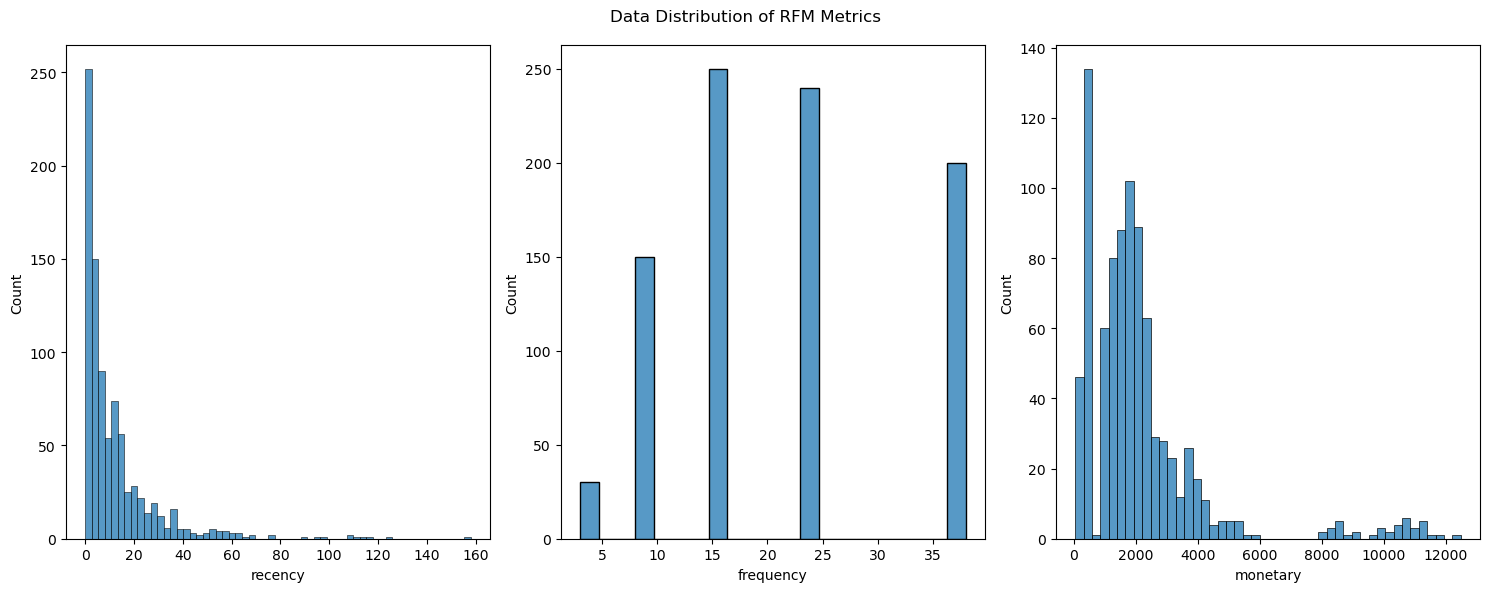

In [20]:
plt.figure(figsize= (15, 6))
plt.suptitle('Data Distribution of RFM Metrics')
for i, column in enumerate(rfm.columns[0:3], start= 1):
    plt.subplot(1, 3, i)
    sns.histplot(data= rfm[column])

plt.tight_layout()

# K-Means Clustering

In [17]:
rfm.iloc[:, 0:3]

,recency,frequency,monetary
customer_id,,,
1,26,15,4835.42
2,5,23,2508.09
3,2,8,368.05
4,27,15,4278.58
5,10,23,7908.89
...,...,...,...
866,8,38,1148.23
867,5,23,2753.45
868,7,15,2071.25


In [18]:
X = rfm.iloc[:, 0:3].copy()

## Scaling 
We will use robust scaler becuase our data is skewed

In [22]:
X = RobustScaler().fit_transform(X)

## Modeling

In [24]:
list_n_cluster = range(2,10)

list_inertia = []
list_sil = []

for i in list_n_cluster:

    kmeans = KMeans(n_clusters= i, random_state=0)
    kmeans.fit(X)

    # inertia untuk elbow mwthod
    inertia = kmeans.inertia_
    list_inertia.append(inertia)

    # silhouette score
    sil = silhouette_score(X, kmeans.labels_)
    list_sil.append(sil)

df_cluster = pd.DataFrame({
    'n_cluster': list_n_cluster,
    'inertia': list_inertia,
    'sil_score': list_sil
})

df_cluster 

c:\Users\msi pc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\msi pc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\msi pc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\msi pc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the envir

,n_cluster,inertia,sil_score
0,2,3738.020850,0.621432
1,3,2365.281013,0.393668
2,4,1411.767405,0.509109
3,5,931.685264,0.540889
4,6,742.873058,0.549414
5,7,567.239791,0.527309
6,8,461.735141,0.535299
7,9,387.874259,0.544917


## Finding Best Number of Cluster

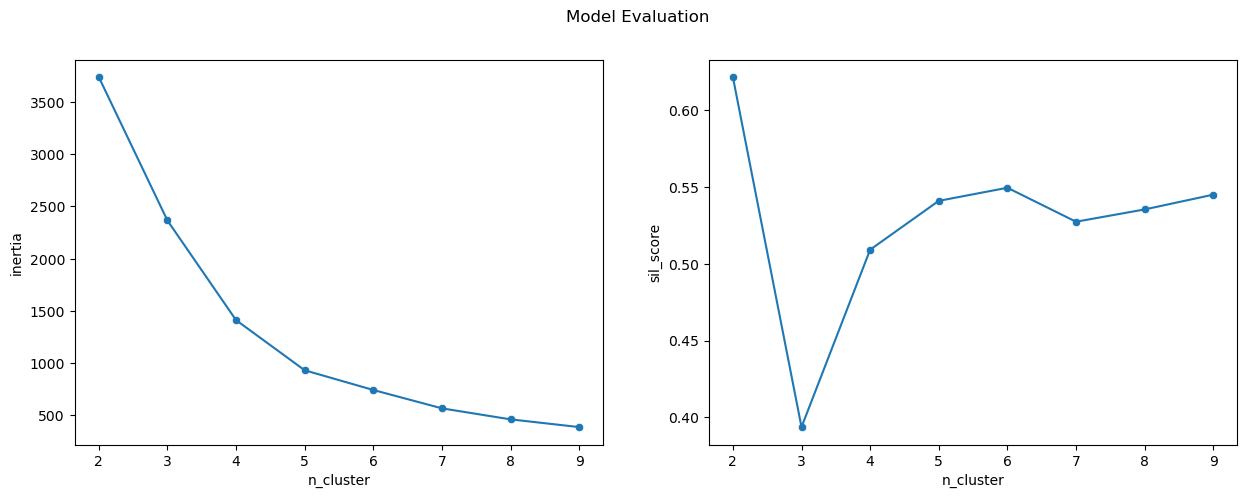

In [28]:
plt.figure(figsize= (15, 5))
plt.suptitle('Model Evaluation')
plt.subplot(1, 2, 1)
sns.lineplot(data= df_cluster, x= 'n_cluster', y= 'inertia')
sns.scatterplot(data= df_cluster, x= 'n_cluster', y= 'inertia')

plt.subplot(1, 2, 2)
sns.lineplot(data= df_cluster, x= 'n_cluster', y= 'sil_score')
sns.scatterplot(data= df_cluster, x= 'n_cluster', y= 'sil_score')

plt.show()

There is no clear elbow that can be seen from the plot, however if we examine the table, the difference in inertia values becomes less significant from 4 clusters onwards. Based on the silhouette score, the optimal number of clusters is 4, as it has a relatively high score above 0.5. A silhouette score above 0.5 usually indicates reasonably well-defined clusters, where there are significant differences in characteristics between clusters.

The final decision on the number of clusters should also take into account business context, not just based on the evaluation of inertia and silhouette score. It is crucial to strike a balance between granularity and practicality, ensuring that the chosen number of clusters aligns with the company's marketing strategies and objective.

For this project we will use 4 clusters.

In [32]:
kmeans_4 = KMeans(n_clusters= 4, random_state= 0)
kmeans_4.fit(X)

cluster_4 = kmeans_4.labels_

c:\Users\msi pc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\msi pc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [33]:
rfm['cluster_4'] = cluster_4 + 1

rfm

,recency,frequency,monetary,product_mode,cluster_4
customer_id,,,,,
1,26,15,4835.42,Non-Food,2
2,5,23,2508.09,Non-Food,2
3,2,8,368.05,Meat,2
4,27,15,4278.58,Non-Food,2
5,10,23,7908.89,Fruit,4
...,...,...,...,...,...
866,8,38,1148.23,Meat,3
867,5,23,2753.45,Non-Food,2
868,7,15,2071.25,Vegetables,2


In [34]:
rfm.groupby('cluster_4')[['recency', 'frequency', 'monetary']].mean()\
    .sort_values('monetary', ascending= False)

,recency,frequency,monetary
cluster_4,,,
4,7.250000,23.000000,10031.290000
2,9.096834,16.599628,2126.443631
3,3.845000,38.000000,1315.365550
1,49.096774,7.806452,532.979140


In [35]:
rfm.groupby('cluster_4').agg({'product_mode': lambda x: x.mode()[0]})

,product_mode
cluster_4,
1,Dairy
2,Non-Food
3,Dairy
4,Non-Food


## Insights:

**Cluster 4**: Recent purchases / High frequency / Highest monetary value
> Cluster 4 consists of the most valuable customers who have made recent and frequent purchases, contributing the most revenue for the business. The most bought product in this segment is non-food.

**Cluster 2**: Moderate purchases / Moderate frequency / Moderate monetary value
> Cluster 2 consists of customers who have made recent purchases and are moderately active compared to those in Cluster 4. They make purchases with a moderate frequency. The most bought product in this segment is non-food.

**Cluster 3**: Most recent purchases / Highest frequency / Low monetary value
> Cluster 3 comprises customers who make very recent and frequent purchases. Although their individual monetary value is lower compared to other clusters, they have a strong tendency to make purchases very recently. The most bought product in this segment is dairy.

**Cluster 1**: Highest recency / Lowest frequency / Lowest monetary value
> Cluster 1 consists of customers who have not made purchases recently and are less frequent spenders. Their individual monetary value is the lowest among the clusters, and they have the lowest frequency of buying. The most bought product in this segment is dairy.

Overall, the 4-cluster segmentation allows the company to better understand the diverse customer groups and formulate marketing strategies accordingly. By providing personalized experiences and targeted offers to each segment, the company can optimize customer retention and increase revenue gain from each customer group.